In [28]:
from PIL import Image
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt

from utils import get_class, plot_to_tensorboard, evaluate, param_counter, CNNClassifier
from CustomImageDataset import CustomImageDataset
from MLPClassifier import MLPClassifier

import os
import io
import numpy as np
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tqdm import tqdm

import mlflow
import mlflow.pytorch

import warnings

In [29]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("mlflow").setLevel(logging.ERROR)

## Load dataset

> Cargar imagenes al dataframe

In [30]:
data_dir = r'data/Split_smol/train/'
p = Path(data_dir).glob('**/*')
files = [(x, get_class(x), Image.open(x).size,Image.open(x)) for x in p if x.is_file()]
df_train = pd.DataFrame(files, columns=["path", "class", "resolution","data"])

data_dir = r'data/Split_smol/val/'
p = Path(data_dir).glob('**/*')
files = [(x, get_class(x), Image.open(x).size,Image.open(x)) for x in p if x.is_file()]
df_val = pd.DataFrame(files, columns=["path", "class", "resolution", "data"])

## Modelo para clasificación de imágenes con MLP

In [31]:
mlflow.set_experiment("CNN_Clasificador_Imagenes")

<Experiment: artifact_location='file:///home/ivan/ITBA/Redes/RN-TP1/mlruns/779117040822828427', creation_time=1751074950104, experiment_id='779117040822828427', last_update_time=1751074950104, lifecycle_stage='active', name='CNN_Clasificador_Imagenes', tags={}>

In [32]:
# Constant definitions

TRAIN_DIR = "data/Split_smol/train/"
VAL_DIR = "data/Split_smol/val/"

batch_size = 32

In [33]:
hparams_space= {
    "model": ("MLPClassifier"),
    "input_size":  [32,64,128],
    "batch_size": [16,32],
    "lr": [1e-3,1e-4],
    "epochs": 200,
    "optimizer":  ["Adam"],
    "HFlip": [0.0,0.5],
    "VFlip": [0.0,0.5],
    "RBContrast": [0.0, 0.5],
    "loss_fn": "CrossEntropyLoss",
    "train_dir": TRAIN_DIR,
    "val_dir": VAL_DIR,
    "es_patience": 10,
    "dropout": [0.0,0.1,0.2,0.3],
    "kernel_size": [3,4],
    "out_channels": [8,16,24]
}

In [34]:
transform_size = hparams_space["input_size"][1]
horizontal_flip = hparams_space["HFlip"][1]
RBContrast = hparams_space["RBContrast"][1]

train_transform = A.Compose([
    A.Resize(transform_size, transform_size),
    A.HorizontalFlip(p=horizontal_flip),
    A.RandomBrightnessContrast(p=RBContrast),
    A.Normalize(),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(transform_size, transform_size),
    A.Normalize(),
    ToTensorV2()
])

In [35]:
train_dataset = CustomImageDataset(TRAIN_DIR, transform=train_transform)
val_dataset   = CustomImageDataset(VAL_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(train_dataset.labels))
model = CNNClassifier(input_size=transform_size ,num_classes=num_classes, dropout=hparams_space["dropout"][1]).to(device)
# model.init_weights()

log_dir = "runs/mlp_experimento_1"
writer = SummaryWriter(log_dir=log_dir)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train CNN

AttributeError: 'numpy.ndarray' object has no attribute 'label_encoder'

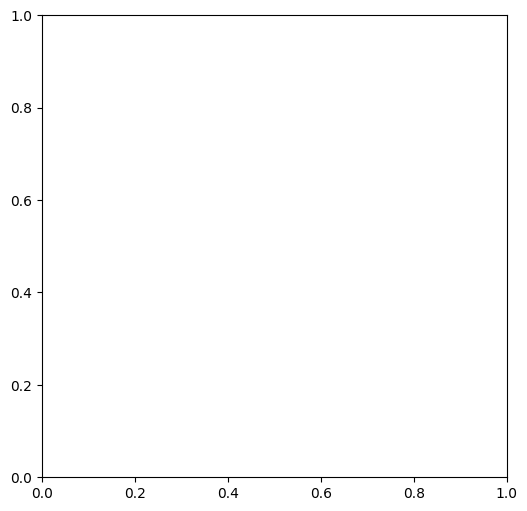

In [ ]:
modelnbr = 0
for input_size in hparams_space["input_size"]:
    for batch_size in hparams_space["batch_size"]:
        for lr in hparams_space["lr"]:
            for optimizer in hparams_space["optimizer"]:
                for HFlip in hparams_space["HFlip"]:
                    for VFlip in hparams_space["VFlip"]:
                        for RBContrast in hparams_space["RBContrast"]:
                            for dropout in hparams_space["dropout"]:
                                for kernel_size in hparams_space["kernel_size"]:
                                    for out_channels in hparams_space["out_channels"]:
                                        if True: #np.random.rand() < 0.05:
                                            print(f"modelo número: {modelnbr}", end = "\r")
                                            modelnbr += 1
                                            hparams= {
                                                "model": ("CNNClassifier"),
                                                "input_size":  input_size,
                                                "batch_size": batch_size,
                                                "lr": lr,
                                                "epochs": 200,
                                                "optimizer": optimizer,
                                                "HFlip": HFlip,
                                                "VFlip": VFlip,
                                                "RBContrast": RBContrast,
                                                "loss_fn": "CrossEntropyLoss",
                                                "train_dir": TRAIN_DIR,
                                                "val_dir": VAL_DIR,
                                                "es_patience": 10,
                                                "dropout": dropout,
                                                "kernel_size": kernel_size,
                                                "out_channels": out_channels,
                                                "model_number": modelnbr
                                            }
                                            train_transform = A.Compose([
                                                A.Resize(hparams["input_size"], hparams["input_size"]),
                                                A.HorizontalFlip(p=hparams["HFlip"]),
                                                A.VerticalFlip(p=hparams["VFlip"]),
                                                A.RandomBrightnessContrast(p=hparams["RBContrast"]),
                                                A.Normalize(),
                                                ToTensorV2()
                                            ])
                                            val_test_transform = A.Compose([
                                                A.Resize(hparams["input_size"], hparams["input_size"]),
                                                A.Normalize(),
                                                ToTensorV2()
                                            ])
                                            train_dataset = CustomImageDataset(hparams["train_dir"], transform=train_transform)
                                            val_dataset   = CustomImageDataset(hparams['val_dir'], transform=val_test_transform)
                                            batch_size = hparams["batch_size"]
                                            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                            val_loader   = DataLoader(val_dataset, batch_size=batch_size)
                                            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                                            num_classes = len(set(train_dataset.labels))
                                            model = CNNClassifier(num_classes=num_classes, input_size = hparams["input_size"], dropout = hparams["dropout"], kernel_size=hparams["kernel_size"],out_channels=hparams["out_channels"]).to(device)
                                            criterion = nn.CrossEntropyLoss()
                                            optimizer = optim.Adam(model.parameters(), lr=hparams["lr"]) if hparams["optimizer"]=="Adam" else optim.SGD(model.parameters(), lr=hparams["lr"])
                                            hparams["count_params"] = param_counter(model)
                                            with mlflow.start_run():
                                                # Log hiperparámetros
                                                mlflow.log_params(hparams)
                                                best_val_acc = 0
                                                best_val_loss = 0
                                                best_train_acc = 0
                                                best_train_loss = 0
                                                best_epoch = 0
                                                for epoch in range(hparams["epochs"]):
                                                    model.train()
                                                    running_loss = 0.0
                                                    correct, total = 0, 0
                                                
                                                    for images, labels in train_loader:
                                                        images, labels = images.to(device), labels.to(device)
                                                
                                                        optimizer.zero_grad()
                                                        outputs = model(images)
                                                        loss = criterion(outputs, labels)
                                                        loss.backward()
                                                        optimizer.step()
                                                
                                                        running_loss += loss.item()
                                                        _, preds = torch.max(outputs, 1)
                                                        correct += (preds == labels).sum().item()
                                                        total += labels.size(0)
                                                
                                                    train_loss = running_loss / len(train_loader)
                                                    train_acc = 100.0 * correct / total
                                                    val_loss, val_acc = evaluate(model, val_loader, writer, device,train_dataset,criterion,epoch=epoch, prefix="val")
                                                
                                                    #print(f"Epoch {epoch+1}:")
                                                    #print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
                                                    #print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
                                                
                                                    writer.add_scalar("train/loss", train_loss, epoch)
                                                    writer.add_scalar("train/accuracy", train_acc, epoch)
                                                
                                                    # Log en MLflow
                                                    mlflow.log_metrics({
                                                        "train_loss": train_loss,
                                                        "train_accuracy": train_acc,
                                                        "val_loss": val_loss,
                                                        "val_accuracy": val_acc
                                                    }, step=epoch)
                                                    if val_acc > best_val_acc:
                                                        best_val_acc = val_acc
                                                        best_val_loss = val_loss
                                                        best_train_acc = train_acc
                                                        best_train_loss = train_loss
                                                        best_epoch = epoch
                                                        # Guardar modelo
                                                        torch.save(model.state_dict(), "mlp_model.pth")
                                                        #print("Modelo guardado como 'mlp_model.pth'")
                                                        mlflow.log_artifact("mlp_model.pth")
                                                        mlflow.pytorch.log_model(model, artifact_path="pytorch_model")
                                                    elif epoch > best_epoch + hparams["es_patience"]:
                                                        #print("Early Stopping")
                                                        break
                                                        
                                                mlflow.log_metrics({
                                                        "train_loss": best_train_loss,
                                                        "train_accuracy": best_train_acc,
                                                        "val_loss": best_val_loss,
                                                        "val_accuracy": best_val_acc,
                                                        "best_epoch": best_epoch
                                                    }, step=epoch+1)                                                
                                                

